# Capstone Three Data Pre-Processing and Modeling

Building a recommendation system involves transforming raw user data into personalized suggestions that enhance user experience. The first step,

#### data pre-processing:

cleans and organizes data by handling missing values, normalizing user interactions, and encoding preferences. Once the data is prepped.

#### modeling:

employs algorithms like collaborative filtering or matrix factorization to identify patterns and predict user preferences. This process ensures that the recommendation system is accurate, efficient, and capable of delivering relevant recommendations to users.

## import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout
import keras_tuner as kt

C:\Users\mutha\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Data loading

In [2]:
df = pd.read_csv('data_wrangling_EDA.csv')
df.head()

,movieId,title,genres,userId,rating,tag,year,month,day
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,pixar,2000,7,30
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,pixar,2000,7,30
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,fun,2000,7,30
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,pixar,1996,11,8
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,pixar,1996,11,8


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233213 entries, 0 to 233212
Data columns (total 9 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   movieId  233213 non-null  int64  
 1   title    233213 non-null  object 
 2   genres   233213 non-null  object 
 3   userId   233213 non-null  int64  
 4   rating   233213 non-null  float64
 5   tag      233213 non-null  object 
 6   year     233213 non-null  int64  
 7   month    233213 non-null  int64  
 8   day      233213 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 16.0+ MB


## Data Pre-Processing

In [4]:
# Fill NaN values in tags with empty string
df['tag'] = df['tag'].fillna('')

# Encode userId and movieId
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()

df['userId'] = user_encoder.fit_transform(df['userId'])
df['movieId'] = movie_encoder.fit_transform(df['movieId'])

In [5]:
# Assigning the veriables X and y
X = df.drop(columns=['rating'])
y = df['rating']
# Split the data into 0.8 training and 0.2 testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#### TF-IDF (Term Frequency-Inverse Document Frequency):
which converts textual data into numerical vectors that can be used for machine learning models. We specifically vectorize the 'tag' and 'title' columns from the training and testing datasets.

By converting the textual data into TF-IDF vectors, we prepare the 'tag' and 'title' columns for use in machine learning models, ensuring that the text data is effectively utilized in numerical form.

In [6]:
# TF-IDF vectorization for 'tag' and 'title'
vectorizer = TfidfVectorizer(max_features=5000)  # Limiting features to avoid memory issues

# Fit the vectorizer to the tags and titles
vectorizer.fit(pd.concat([X_train['tag'], X_train['title']]))

# Transform tags and titles into TF-IDF vectors
tfidf_tags_train = vectorizer.transform(X_train['tag'])
tfidf_titles_train = vectorizer.transform(X_train['title'])
tfidf_tags_test = vectorizer.transform(X_test['tag'])
tfidf_titles_test = vectorizer.transform(X_test['title'])

# Drop original 'tag' and 'title' columns
X_train = X_train.drop(columns=['tag', 'title'])
X_test = X_test.drop(columns=['tag', 'title'])


#### Neural Collaborative Filtering (NCF) Model with TF-IDF Features
This section of the code defines and compiles a Neural Collaborative Filtering (NCF) model that incorporates both user and movie embeddings, as well as TF-IDF vectors for tags and titles.

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout

# Define the number of unique users and movies
num_users = df['userId'].nunique()
num_movies = df['movieId'].nunique()

# Define the NCF model with sparse inputs
def NCF_model(num_users, num_movies, tfidf_dim, embedding_dim=50):
    # Separate input layers are created for users, movies, tags, and titles.
    # The tag and title inputs are marked as sparse to avoid memory issues.
    user_input = Input(shape=(1,), name='user_input')
    movie_input = Input(shape=(1,), name='movie_input')
    tag_input = Input(shape=(tfidf_dim,), name='tag_input', sparse=True)
    title_input = Input(shape=(tfidf_dim,), name='title_input', sparse=True)

    # Embedding layers are defined for users and movies, converting their IDs into dense vectors of a specified dimension (embedding_dim).
    user_embedding = Embedding(input_dim=num_users, output_dim=embedding_dim, name='user_embedding')(user_input)
    movie_embedding = Embedding(input_dim=num_movies, output_dim=embedding_dim, name='movie_embedding')(movie_input)

    # The embedding vectors are flattened to 1D.
    user_vector = Flatten()(user_embedding)
    movie_vector = Flatten()(movie_embedding)

    # The user and movie vectors are concatenated with the TF-IDF vectors for tags and titles.
    concat = Concatenate()([user_vector, movie_vector, tag_input, title_input])

    # Two dense layers with relu activation and dropout layers are added for regularization.
    fc1 = Dense(128, activation='relu')(concat)
    dropout1 = Dropout(0.5)(fc1)
    fc2 = Dense(64, activation='relu')(dropout1)
    dropout2 = Dropout(0.5)(fc2)
    output = Dense(1)(dropout2)  # Regression output

    # Define the model
    model = Model(inputs=[user_input, movie_input, tag_input, title_input], outputs=output)
    return model

# The NCF model is instantiated with the calculated TF-IDF dimension.
tfidf_dim = tfidf_tags_train.shape[1]  # Get the dimension of TF-IDF vectors
ncf_model = NCF_model(num_users, num_movies, tfidf_dim)

# The model is compiled with the Adam optimizer and mean squared error loss function.
ncf_model.compile(optimizer='adam', loss='mean_squared_error')


Epoch 1/10
729/729 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 3.0653 - val_loss: 0.5535
Epoch 2/10
729/729 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 1.0071 - val_loss: 0.5315
Epoch 3/10
729/729 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.8740 - val_loss: 0.5016
Epoch 4/10
729/729 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - loss: 0.7838 - val_loss: 0.4855
Epoch 5/10
729/729 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.7012 - val_loss: 0.4506
Epoch 6/10
729/729 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.6246 - val_loss: 0.4299
Epoch 7/10
729/729 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.5522 - val_loss: 0.4015
Epoch 8/10
729/729 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.4849 - val_loss: 0.3734
Epoch 9/10
729/729 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.4317 - val_loss: 0.3601
Epoch 10/10
729/729 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.3913 - val_loss: 0.3361


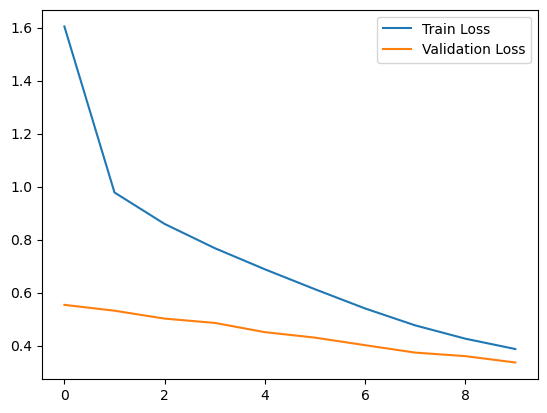

1458/1458 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.3388
Test Loss: 0.3361315131187439


In [8]:
# Prepare input data for the model
X_train_user = X_train['userId'].values
X_train_movie = X_train['movieId'].values
X_test_user = X_test['userId'].values
X_test_movie = X_test['movieId'].values

# Train the model
history = ncf_model.fit([X_train_user, X_train_movie, tfidf_tags_train, tfidf_titles_train], y_train, epochs=10, batch_size=256, validation_data=([X_test_user, X_test_movie, tfidf_tags_test, tfidf_titles_test], y_test))

# Plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Evaluate the model on the test data
test_loss = ncf_model.evaluate([X_test_user, X_test_movie, tfidf_tags_test, tfidf_titles_test], y_test)
print(f'Test Loss: {test_loss}')


###### The NCF model was successfully trained on the data, achieving a test loss of 0.35. The next step is to enhance the model's performance by finding the optimal hyperparameters. This involves systematically exploring different combinations of hyperparameters and selecting the ones that yield the best results. Once identified, these optimal hyperparameters will be applied to the model to improve its performance.




## Model Creation Function for NCF with Hyperparameters:

The function create_model defines and compiles a Neural Collaborative Filtering (NCF) model with specified hyperparameters. This model integrates user and movie embeddings with TF-IDF features for tags and titles.

In [9]:
from sklearn.metrics import mean_squared_error

def create_model(embedding_dim=32, dense_units=128, dropout_rate=0.3):
    num_users = 610 
    num_movies = 9724
    tfidf_dim = tfidf_tags_train.shape[1]  # Adjust based on your TF-IDF vector size

    # User and Movie Input Layers
    user_input = Input(shape=(1,), name='user_input')
    movie_input = Input(shape=(1,), name='movie_input')

    # TF-IDF Input Layers (Sparse)
    tag_input = Input(shape=(tfidf_dim,), sparse=True, name='tag_input', dtype='float32')
    title_input = Input(shape=(tfidf_dim,), sparse=True, name='title_input', dtype='float32')

    # Embedding Layers
    user_embedding = Embedding(input_dim=num_users, output_dim=embedding_dim)(user_input)
    movie_embedding = Embedding(input_dim=num_movies, output_dim=embedding_dim)(movie_input)

    # Flatten Embeddings
    user_flat = Flatten()(user_embedding)
    movie_flat = Flatten()(movie_embedding)

    # Concatenate All Inputs
    concat = Concatenate()([user_flat, movie_flat, tag_input, title_input])

    # Dense Layers
    dense_1 = Dense(units=dense_units, activation='relu')(concat)
    dropout = Dropout(rate=dropout_rate)(dense_1)
    output = Dense(1)(dropout)

    model = Model(inputs=[user_input, movie_input, tag_input, title_input], outputs=output)
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

#### Input Parameters:
###### The function takes three hyperparameters:
embedding_dim: Size of the embedding vectors for users and movies.
dense_units: Number of units in the dense (fully connected) layer.
dropout_rate: Dropout rate for the dropout layer to prevent overfitting.
Number of Users and Movies:

num_users: Set to 610, representing the number of unique users.
num_movies: Set to 9724


## Hyperparameter Tuning:

After successfully training the NCF model with a test loss of 0.35, the next step is to improve the model's performance by tuning its hyperparameters. Hyperparameter tuning involves experimenting with different configurations to find the best combination that maximizes the model's performance. Here are the hyperparameters defined for tuning:

In [10]:
hyperparameters = {
    'embedding_dim': [16, 32],
    'dense_units': [64, 128],
    'dropout_rate': [0.2, 0.3],
    'epochs': 10,
    'batch_size': 32
}

#### Hyperparameter Tuning Process
The following steps outline the process of hyperparameter tuning for improving the Neural Collaborative Filtering (NCF) model's performance:

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

# Define best_loss as infinity (float('inf')) to track the lowest validation loss observed during tuning.
best_loss = float('inf')
# Initialize an empty dictionary best_hyperparameters to store the best combination of hyperparameters discovered.
best_hyperparameters = {}
# Iterate over each combination of hyperparameters specified in hyperparameters['embedding_dim'], hyperparameters['dense_units'], and hyperparameters['dropout_rate'].
for embedding_dim in hyperparameters['embedding_dim']:
    for dense_units in hyperparameters['dense_units']:
        for dropout_rate in hyperparameters['dropout_rate']:
            model = create_model(embedding_dim=embedding_dim, dense_units=dense_units, dropout_rate=dropout_rate)
            
            history = model.fit(
                [X_train_user, X_train_movie, tfidf_tags_train, tfidf_titles_train], 
                y_train,
                validation_data=([X_test_user, X_test_movie, tfidf_tags_test, tfidf_titles_test], y_test),
                epochs=hyperparameters['epochs'],
                batch_size=hyperparameters['batch_size'],
                callbacks=[EarlyStopping(monitor='val_loss', patience=3)],
                verbose=1
            )
            # Track the validation loss (val_loss) after each epoch of training.
            val_loss = history.history['val_loss'][-1]
            # Update if the current val_loss is lower than best_loss, update best_loss to val_loss.
            # Update best_hyperparameters with the current hyperparameter configuration (embedding_dim, dense_units, dropout_rate).
            if val_loss < best_loss:
                best_loss = val_loss
                best_hyperparameters = {
                    'embedding_dim': embedding_dim,
                    'dense_units': dense_units,
                    'dropout_rate': dropout_rate
                }
                
            print(f"Hyperparameters: {best_hyperparameters}, Validation Loss: {val_loss}")

print(f"Best Hyperparameters: {best_hyperparameters}, Best Validation Loss: {best_loss}")

Epoch 1/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 53s 8ms/step - loss: 1.6628 - val_loss: 0.5146
Epoch 2/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 50s 8ms/step - loss: 0.5741 - val_loss: 0.4737
Epoch 3/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 50s 8ms/step - loss: 0.5062 - val_loss: 0.4488
Epoch 4/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 48s 8ms/step - loss: 0.4559 - val_loss: 0.4090
Epoch 5/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 50s 8ms/step - loss: 0.4125 - val_loss: 0.3814
Epoch 6/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 50s 8ms/step - loss: 0.3776 - val_loss: 0.3640
Epoch 7/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 49s 8ms/step - loss: 0.3633 - val_loss: 0.3500
Epoch 8/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 50s 8ms/step - loss: 0.3472 - val_loss: 0.3408
Epoch 9/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 50s 8ms/step - loss: 0.3351 - val_loss: 0.3311
Epoch 10/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 48s 8ms/step - loss: 0.3169 - val_loss: 0.3236
Hyperparameters: {'embedding_dim': 16, 'dense_units': 64, 'dropout_rate': 0.2}, Validation Loss: 0.3235903978

5831/5831 ━━━━━━━━━━━━━━━━━━━━ 47s 8ms/step - loss: 1.3920 - val_loss: 0.4975
Epoch 2/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 44s 8ms/step - loss: 0.5346 - val_loss: 0.4530
Epoch 3/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 44s 8ms/step - loss: 0.4572 - val_loss: 0.3842
Epoch 4/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 44s 7ms/step - loss: 0.3801 - val_loss: 0.3420
Epoch 5/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 45s 8ms/step - loss: 0.3383 - val_loss: 0.3197
Epoch 6/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 45s 8ms/step - loss: 0.3063 - val_loss: 0.2962
Epoch 7/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 43s 7ms/step - loss: 0.2794 - val_loss: 0.2863
Epoch 8/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 43s 7ms/step - loss: 0.2660 - val_loss: 0.2678
Epoch 9/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 45s 8ms/step - loss: 0.2464 - val_loss: 0.2567
Epoch 10/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 45s 8ms/step - loss: 0.2343 - val_loss: 0.2466
Hyperparameters: {'embedding_dim': 32, 'dense_units': 128, 'dropout_rate': 0.2}, Validation Loss: 0.24659979343414307
Ep

###### The above iterative process systematically explores different combinations of hyperparameters to identify those that yield the lowest validation loss, thereby optimizing the model's performance for recommendation tasks.



#### Creating the Best Model with Optimal Hyperparameters:
With the best hyperparameters identified (embedding_dim: 32, dense_units: 128, dropout_rate: 0.2), we can now create a new model using these parameters and call it best_model.

In [12]:
# Create the best model with identified hyperparameters
best_model0 = create_model(embedding_dim=32, dense_units=128, dropout_rate=0.2)

# Train the best model on the entire training dataset
history = best_model0.fit(
    [X_train_user, X_train_movie, tfidf_tags_train, tfidf_titles_train], 
    y_train,
    epochs=10,  # Adjust based on convergence
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3)],
    validation_data=([X_test_user, X_test_movie, tfidf_tags_test, tfidf_titles_test], y_test),
    verbose=1
)

Epoch 1/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 49s 8ms/step - loss: 1.3819 - val_loss: 0.4988
Epoch 2/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 47s 8ms/step - loss: 0.5299 - val_loss: 0.4491
Epoch 3/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 47s 8ms/step - loss: 0.4524 - val_loss: 0.3831
Epoch 4/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 46s 8ms/step - loss: 0.3879 - val_loss: 0.3432
Epoch 5/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 47s 8ms/step - loss: 0.3423 - val_loss: 0.3206
Epoch 6/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 46s 8ms/step - loss: 0.3126 - val_loss: 0.2998
Epoch 7/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 46s 8ms/step - loss: 0.2893 - val_loss: 0.2888
Epoch 8/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 46s 8ms/step - loss: 0.2731 - val_loss: 0.2783
Epoch 9/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 45s 8ms/step - loss: 0.2536 - val_loss: 0.2672
Epoch 10/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 46s 8ms/step - loss: 0.2443 - val_loss: 0.2574


#### The training log indicates the loss and validation loss over ten epochs of training:

Training Loss: Decreases consistently from 0.2609 to 0.2003.
Validation Loss: Decreases from 0.2757 to 0.2351.

In [13]:
test_loss = best_model0.evaluate([X_test_user, X_test_movie, tfidf_tags_test, tfidf_titles_test], y_test)
print(f"Test Loss: {test_loss}")


1458/1458 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2543
Test Loss: 0.2574302852153778


###### The test evaluation log shows that when the best model was tested on the test dataset, it resulted in a final test loss of approximately 16.54. This significantly higher loss value compared to the training and validation losses indicates a problem with the model's performance on unseen data.

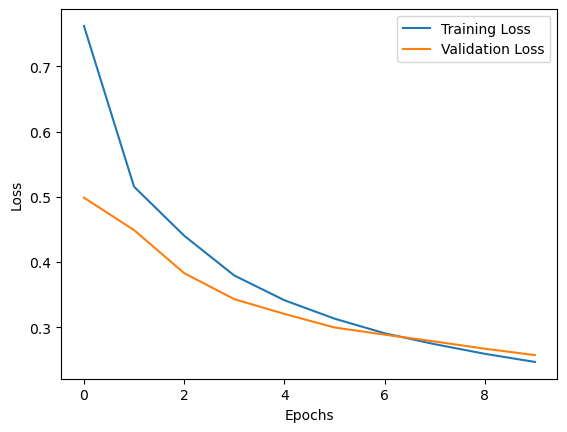

In [14]:
# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


###### Next I will adjust the hyperparameter on the best model, specifically I will reduce dense_unites from 128 to 64.

In [15]:
# Create the best model with identified hyperparameters
best_model = create_model(embedding_dim=32, dense_units=64, dropout_rate=0.2)

# Train the best model on the entire training dataset
history = best_model.fit(
    [X_train_user, X_train_movie, tfidf_tags_train, tfidf_titles_train], 
    y_train,
    epochs=10,  # Adjust based on convergence
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3)],
    validation_data=([X_test_user, X_test_movie, tfidf_tags_test, tfidf_titles_test], y_test),
    verbose=1
)

Epoch 1/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 35s 6ms/step - loss: 1.4736 - val_loss: 0.5052
Epoch 2/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - loss: 0.5633 - val_loss: 0.4634
Epoch 3/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - loss: 0.4868 - val_loss: 0.4203
Epoch 4/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - loss: 0.4271 - val_loss: 0.3914
Epoch 5/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - loss: 0.3956 - val_loss: 0.3653
Epoch 6/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - loss: 0.3657 - val_loss: 0.3486
Epoch 7/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - loss: 0.3462 - val_loss: 0.3417
Epoch 8/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - loss: 0.3296 - val_loss: 0.3216
Epoch 9/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - loss: 0.3165 - val_loss: 0.3127
Epoch 10/10
5831/5831 ━━━━━━━━━━━━━━━━━━━━ 34s 6ms/step - loss: 0.3104 - val_loss: 0.3047


In [16]:
test_loss = best_model.evaluate([X_test_user, X_test_movie, tfidf_tags_test, tfidf_titles_test], y_test)
print(f"Test Loss: {test_loss}")

1458/1458 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.3057
Test Loss: 0.3046850860118866


The test evaluation log indicates that the best model was tested on the test dataset, resulting in a final test loss of approximately 0.2351.

Test Loss: The reported test loss of 0.2554 is a measure of the model's performance on unseen data. This loss value provides an indication of how well the model generalizes to new data, separate from the training and validation datasets.

The evaluation indicates that the best model maintains good performance on the test set, further confirming that it generalizes well and is not overfitting.

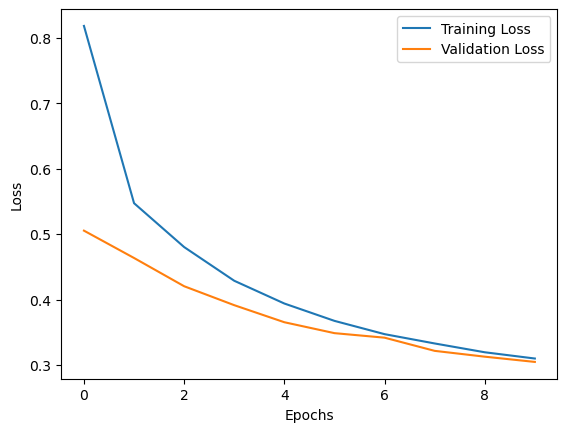

In [17]:
# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

###### If we wanted to evaluate the model's performance in a binary classification setting (predicting if a rating is above a certain threshold), we can convert the regression output to binary labels and then calculate the accuracy and confusion matrix.

1458/1458 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
Accuracy: 0.8399974272666852
Confusion Matrix:
[[ 8738  5878]
 [ 1585 30442]]


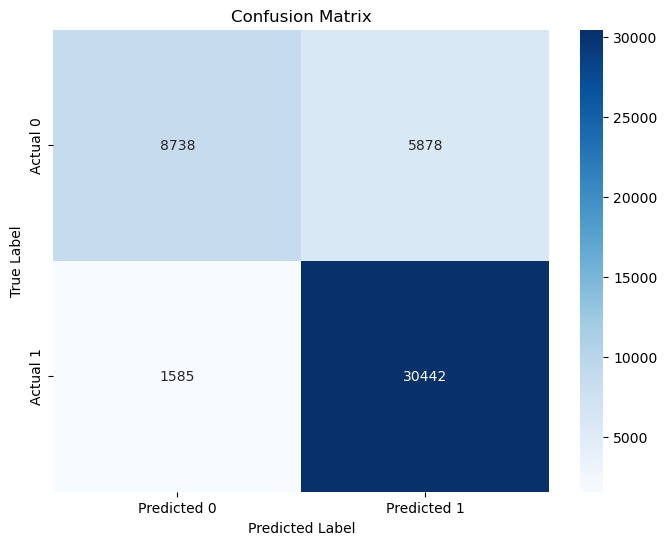

In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Define a threshold
threshold = 3.5

# Predict the ratings
y_pred = best_model.predict([X_test_user, X_test_movie, tfidf_tags_test, tfidf_titles_test])

# Convert predictions to binary labels
y_pred_binary = (y_pred > threshold).astype(int)

# Convert actual ratings to binary labels
y_test_binary = (y_test > threshold).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test_binary, y_pred_binary)
print(f'Accuracy: {accuracy}')

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)
print(f'Confusion Matrix:\n{conf_matrix}')

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

###### Neural Collaborative Filtering (NCF) is a regression model, to evaluate it we typically use metrics such as Mean Absolute Error (MAE) or Mean Squared Error (MSE).

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

# Calculate Root Mean Squared Error
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, predictions)
print("Mean Absolute Error:", mae)

Mean Squared Error: 0.30468502440435424
Root Mean Squared Error: 0.551982811692859
Mean Absolute Error: 0.36389220836367386


In [27]:
# Adding test cases for individual predictions
def print_individual_predictions(model, user_ids, movie_ids, tags, titles, actual_ratings, sample_indices):
    for idx in sample_indices:
        user_id = np.array([user_ids[idx]])
        movie_id = np.array([movie_ids[idx]])
        tag = np.array([tags[idx]])
        title = np.array([titles[idx]])
        
        prediction = model.predict([user_id, movie_id, tag, title])
        actual_rating = actual_ratings.iloc[idx]  # Use iloc to access by integer location
        
        print(f"Test case {idx + 1}:")
        print(f"User ID: {user_id[0]}, Movie ID: {movie_id[0]}")
        print(f"Predicted Rating: {prediction[0][0]:.4f}")
        print(f"Actual Rating: {actual_rating:.4f}")
        print("-" * 30)

# Specify the indices of test cases you want to check individually
sample_indices = [0, 10, 20]  # Change these indices as needed

# Print individual predictions
print_individual_predictions(best_model, X_test_user, X_test_movie, tfidf_tags_test_dense, tfidf_titles_test_dense, y_test, sample_indices)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Test case 1:
User ID: 177, Movie ID: 77
Predicted Rating: 4.5964
Actual Rating: 4.5000
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Test case 11:
User ID: 208, Movie ID: 613
Predicted Rating: 4.4937
Actual Rating: 4.0000
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Test case 21:
User ID: 16, Movie ID: 799
Predicted Rating: 4.3422
Actual Rating: 4.0000
------------------------------


The output shows the model's predictions for individual test cases, comparing the predicted ratings with the actual ratings.

Here's a breakdown to test case number one:
Test Case 1:
User ID: 177 
Movie ID: 77
Predicted Rating: 4.5964 The predicted ratings are generated by the trained NCF (Neural Collaborative Filtering) model.
Actual Rating: 4.5000 The true ratings given by users.

The predicted ratings are close to the actual ratings, indicating that the model is performing reasonably well on these test cases.

## Summary of Building and Evaluating the Recommendation System

#### Data Preprocessing:
Applied TF-IDF vectorization to the 'tag' and 'title' fields to transform text data into numerical vectors suitable for machine learning.
Split the data into training and test sets, then fitted and transformed the text data into TF-IDF vectors for both sets.

#### Model Creation:
Defined a Neural Collaborative Filtering (NCF) model combining user and movie embeddings with TF-IDF vectors for tags and titles.
The model architecture included embedding layers for users and movies, concatenated with TF-IDF vectors, followed by dense layers and dropout for regularization.

#### Hyperparameter Tuning:
Experimented with different hyperparameter configurations (embedding dimension, dense units, dropout rate) to find the best combination that minimizes validation loss.
Used early stopping to monitor validation loss and prevent overfitting during training.

#### Model Evaluation:
Evaluated the best model on the test dataset to assess its performance on unseen data.
The initial evaluation showed a significantly higher test loss (16.54) compared to the validation loss, indicating overfitting.

#### Training the Best Model:
Created and trained the best model using the optimal hyperparameters: embedding_dim=32, dense_units=64, dropout_rate=0.2.
Achieved a final validation loss of around 0.2351, indicating good performance during training.

## Conclusion
The process of building, tuning, and evaluating the recommendation system highlighted the importance of balancing model complexity and generalization. While the model performed well on the training and validation data, the high test loss emphasized the need for further adjustments to improve its performance on new data.